# Spam Vs. Ham Classifier

## Import dependencies

In [1]:

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

from wordcloud import WordCloud

import nltk 
from nltk.corpus import stopwords

from transformers import GPT2Tokenizer

import spacy

from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer

import joblib

from custom_transformers import Renamer, FeatureGenerator, TextPreprocessor

import re

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Loading the dataset

In [2]:
# Load data
df = pd.read_csv('./data/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Droping & Renaming columns

In [4]:
# droping columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [5]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# rename the columns
df.rename(columns={'v1': 'label', 'v2':'message'}, inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# re-order columns
df = df.reindex(labels=['message', 'label'], axis=1)
df.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


## Explore the data

Text(0.5, 0, 'Message type')

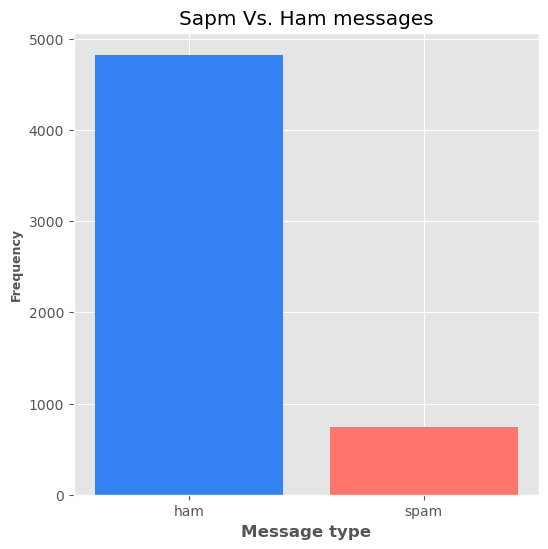

In [8]:
labels = df['label'].value_counts().index
heights = df['label'].value_counts().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(labels, heights, color=["#3481F4", '#FF746C'])

ax.set_title("Sapm Vs. Ham messages")
ax.set_ylabel("Frequency", fontsize=9, fontweight="bold")
ax.set_xlabel("Message type", fontweight="bold")

(-0.5, 599.5, 399.5, -0.5)

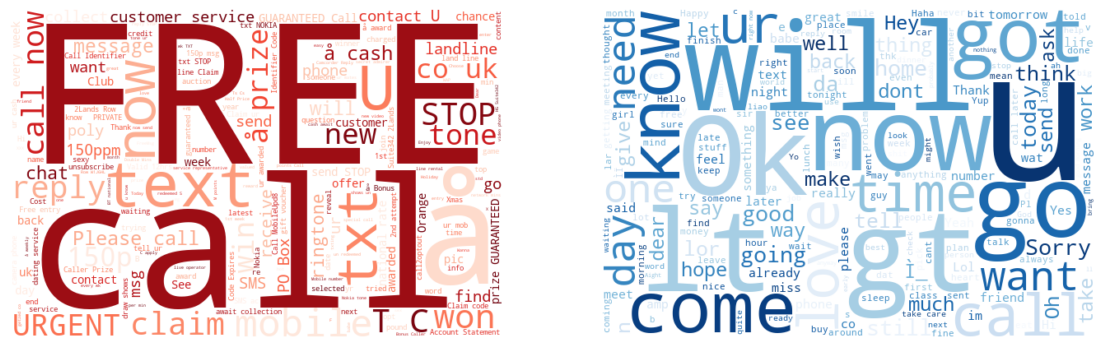

In [9]:
spam_text = ' '.join(df[df['label'] == 'spam']['message'])
ham_text = ' '.join(df[df['label'] == 'ham']['message'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
spam_wc = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(spam_text)
ax1.imshow(spam_wc, interpolation='bilinear')
ax1.axis('off')

ham_wc = spam_wc = WordCloud(width=600, height=400, background_color='white', colormap='Blues').generate(ham_text)
ax2.imshow(ham_wc, interpolation='bilinear')
ax2.axis('off')

## Handle duplicated messages

In [10]:
df.duplicated(subset='message').value_counts()

False    5169
True      403
Name: count, dtype: int64

In [11]:
# drop duplicated messages
df.drop_duplicates(subset='message', keep='last', ignore_index=True, inplace=True)

In [12]:
df.duplicated(subset='message').value_counts()

False    5169
Name: count, dtype: int64

## Feature Engineering

In [13]:
# create the message_length feature
df['message_length'] = df['message'].apply(len)
df.head()

,message,label,message_length
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,U dun say so early hor... U c already then say...,ham,49
3,"Nah I don't think he goes to usf, he lives aro...",ham,61
4,FreeMsg Hey there darling it's been 3 week's n...,spam,148


In [14]:
# add the num_digits column
def num_digits(text):
    matches = re.findall('\d', text)
    return len(matches)
df['num_digits'] = df['message'].apply(num_digits)

In [15]:
df.head()

,message,label,message_length,num_digits
0,"Go until jurong point, crazy.. Available only ...",ham,111,0
1,Ok lar... Joking wif u oni...,ham,29,0
2,U dun say so early hor... U c already then say...,ham,49,0
3,"Nah I don't think he goes to usf, he lives aro...",ham,61,0
4,FreeMsg Hey there darling it's been 3 week's n...,spam,148,4


In [16]:
# create the has_link column 
def has_link(text):
    match = re.search(r'[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_+.~#?&//=]*)', text)
    if bool(match):
        return 1 
    else:
        return 0

df['has_link'] = df['message'].apply(has_link)

In [17]:
df.head()

,message,label,message_length,num_digits,has_link
0,"Go until jurong point, crazy.. Available only ...",ham,111,0,0
1,Ok lar... Joking wif u oni...,ham,29,0,0
2,U dun say so early hor... U c already then say...,ham,49,0,0
3,"Nah I don't think he goes to usf, he lives aro...",ham,61,0,0
4,FreeMsg Hey there darling it's been 3 week's n...,spam,148,4,1


In [18]:
# add the has_email column
def has_email(text):
    match = re.search(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b', text)
    if bool(match):
        return 1
    else: 
        return 0
df['has_email'] = df['message'].apply(has_email)

In [19]:
# add the is_question column
def is_question(text):
    match = re.search(r'\?$', text.strip())
    if bool(match):
        return 1
    else: 
        return 0
df['is_question'] = df['message'].apply(is_question)

In [20]:
spam_keywords = [
    "free", "win", "winner", "cash", "prize", "credit", "urgent",
    "claim", "offer", "now", "limited", "click", "buy", "cheap",
    "guaranteed", "access", "trial", "money", "investment", "deal",
    "loan", "congratulations", "bonus", "discount", "promo",
    "act now", "don’t delete", "this won’t last", "exclusive"
]

def contain_spam_keywords(text):
    i = 0
    while (i < len(spam_keywords)):
        if spam_keywords[i] in text.lower():
            break 
        i+=1
    if i < len(spam_keywords):
        return 1 
    else:
        return 0

df['contain_spam_keywords'] = df['message'].apply(contain_spam_keywords) 

In [21]:
# add the spam_words_count column
def spam_words_count(text):
    i = 0
    for word in spam_keywords:
        if word in text.lower():
            i+=1
    return i
df['spam_keywords_count'] = df['message'].apply(spam_words_count)

In [22]:
# add the starts_with_greetings column
greetings = [
    "hi", "hello", "dear", "greetings", "hey", "good morning", "good afternoon", "good evening",
    "what's up", "yo", "howdy", "hiya", "sup", "to whom it may concern", "dearest",
    "dear friend", "dear customer", "dear user", "attention", "dear valued customer"
]

def stats_with_greeting(text):
   text = text.lower().strip()
   return int(any(text.startswith(greet) for greet in greetings))

df['starts_with_greeting'] = df['message'].apply(stats_with_greeting)

In [23]:
# add the has_closing column
signature_closings = [
    "regards",
    "best regards",
    "kind regards",
    "warm regards",
    "with regards",
    "sincerely",
    "yours sincerely",
    "yours truly",
    "truly yours",
    "faithfully yours",
    "with gratitude",
    "thank you",
    "thanks",
    "many thanks",
    "thanks in advance",
    "cheers",
    "respectfully",
    "warm wishes",
    "best wishes",
    "all the best",
    "have a great day",
    "take care",
    "talk soon",
    "stay safe"
]

def has_closing(text):
    text = text[-100:]
    return int(any(closing in text.lower().strip() for closing in signature_closings))

df['has_closing'] = df['message'].apply(has_closing)

In [24]:
# add the num_sepcail_chars column
def num_special_chars(text):
    matches = re.findall(r'[^a-zA-Z0-9\s\.,]', text.lower().strip())
    return len(matches)

df['num_sepcail_chars'] = df['message'].apply(num_special_chars)

In [25]:
# add the num_exclamation_marks column
def num_exclamation_marks(text):
    return text.count('!')

df['num_excalamation_marks'] = df['message'].apply(num_exclamation_marks)

In [26]:
# add the number_upper_words column
def number_upper_words(text):
    words = text.split()
    return sum(1 for word in words if word.isupper())
df['number_upper_words'] = df['message'].apply(number_upper_words)

In [27]:
df_copy = df.copy()

## Text Preprocessing

In [28]:
# Remove punctuations and numbers 
def remove_punctuations_numbers(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text 

df['message_cleaned'] = df['message'].apply(remove_punctuations_numbers)

In [29]:
# Transform text to lowercase
def lowercase_text(text):
    return text.lower()
df['message_cleaned'] = df['message'].apply(lowercase_text)

### Lemmatization

In [30]:
# Lemmatization
nlp = spacy.load('en_core_web_sm')
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['message_cleaned'] = df['message_cleaned'].apply(lemmatize_text)

### Tokenization

In [31]:
# BPE tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
joblib.dump(tokenizer, './models/tokenizer.joblib')
def tokenize(text):
    return tokenizer.tokenize(text)
df['message_cleaned'] = df['message_cleaned'].apply(tokenize)

### Stopwords

In [32]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
def clean_token(token):
    return token.lower().strip("Ġ")

def remove_stopwords(tokens):
    return [token for token in tokens if clean_token(token) not in stop_words]

df['message_cleaned'] = df['message_cleaned'].apply(remove_stopwords)

In [33]:
df['message_cleaned'].head()

0    [go, Ġuntil, Ġjur, ong, Ġpoint, Ġ,, Ġcrazy, Ġ....
1           [ok, Ġlar, Ġ..., Ġjoke, Ġw, Ġu, Ġon, Ġ...]
2    [u, Ġdun, Ġsay, Ġso, Ġearly, Ġhor, Ġ..., Ġu, Ġ...
3    [nah, ĠI, Ġdo, Ġnot, Ġthink, Ġhe, Ġgo, Ġto, Ġu...
4    [fre, ems, g, Ġhey, Ġthere, Ġd, ar, le, Ġit, Ġ...
Name: message_cleaned, dtype: object

### Word Embeeding

In [34]:
# Skip-gram 
df.to_csv('./data/cleaned.csv')
sentences = df['message_cleaned']
model_embeeding = Word2Vec(
    sentences,
    vector_size = 100,
    window = 5,
    min_count = 1,
    sg = 1
)
joblib.dump(model_embeeding, 'word2vec.joblib')

['word2vec.joblib']

In [35]:
def vectorize_sentence(sentence):
    vectors = [model_embeeding.wv[token] for token in sentence if token in model_embeeding.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model_embeeding.vector_size)

X = np.array([vectorize_sentence(sentence) for sentence in df['message_cleaned']])

df_embeddings = pd.DataFrame(X)

df = pd.concat([df, df_embeddings], axis=1)

## Modeling

### Feature Scaling 

In [36]:
# z-score scaling
X = df.drop(columns=['message', 'label', 'message_cleaned'])
X.columns = X.columns.astype(str)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns.astype(str))

In [37]:
def label_encoding(label):
    if label == "spam":
        return 1
    else:
        return 0
    
y = df['label'].apply(label_encoding)

### Random Forest

In [38]:
rnd_forest_clf = RandomForestClassifier(n_jobs=-1)

In [39]:
# StratifiedKfold evaluation
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
accuracy, precision, recall, f1 = [], [], [], []
all_y_true, all_y_pred = [], []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    rnd_forest_clf.fit(X.iloc[train_index], y[train_index])
    y_pred = rnd_forest_clf.predict(X.iloc[test_index])
    
    all_y_true.extend(y[test_index])
    all_y_pred.extend(y_pred)
    
    accuracy.append(accuracy_score(y[test_index], y_pred))
    precision.append(precision_score(y[test_index], y_pred))
    recall.append(recall_score(y[test_index], y_pred))
    f1.append(f1_score(y[test_index], y_pred))
    
print(f"Avergae model accuracy: {round(sum(accuracy) / len(accuracy), 2)}")
print(f"Avergae model precision: {round(sum(precision) / len(precision), 2)}")
print(f"Avergae model recall: {round(sum(recall) / len(recall), 2)}")
print(f"Avergae model f1-score: {round(sum(f1) / len(f1), 2)}")

Avergae model accuracy: 0.99
Avergae model precision: 0.99
Avergae model recall: 0.92
Avergae model f1-score: 0.96


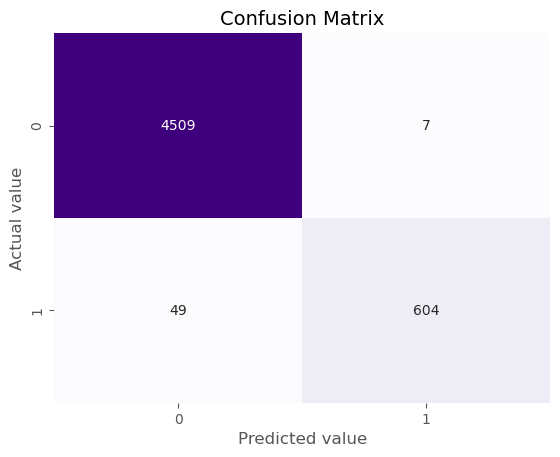

In [40]:
# confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d", cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted value', fontsize=12)
plt.ylabel('Actual value', fontsize=12)
plt.show()

In [41]:
print(classification_report(all_y_true, all_y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4516
           1       0.99      0.92      0.96       653

    accuracy                           0.99      5169
   macro avg       0.99      0.96      0.97      5169
weighted avg       0.99      0.99      0.99      5169



### XGBoost 

In [42]:
xgb_clf = XGBClassifier()
model = XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

accuracy, precision, recall, f1 = [], [], [], []
all_y_true, all_y_pred = [], []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    xgb_clf.fit(X.iloc[train_index], y[train_index])
    y_pred = xgb_clf.predict(X.iloc[test_index])
    
    all_y_true.extend(y[test_index])
    all_y_pred.extend(y_pred)
    
    accuracy.append(accuracy_score(y[test_index], y_pred))
    precision.append(precision_score(y[test_index], y_pred))
    recall.append(recall_score(y[test_index], y_pred))
    f1.append(f1_score(y[test_index], y_pred))
    
print(f"Avergae model accuracy: {round(sum(accuracy) / len(accuracy), 2)}")
print(f"Avergae model precision: {round(sum(precision) / len(precision), 2)}")
print(f"Avergae model recall: {round(sum(recall) / len(recall), 2)}")
print(f"Avergae model f1-score: {round(sum(f1) / len(f1), 2)}")

Avergae model accuracy: 0.99
Avergae model precision: 0.99
Avergae model recall: 0.94
Avergae model f1-score: 0.96


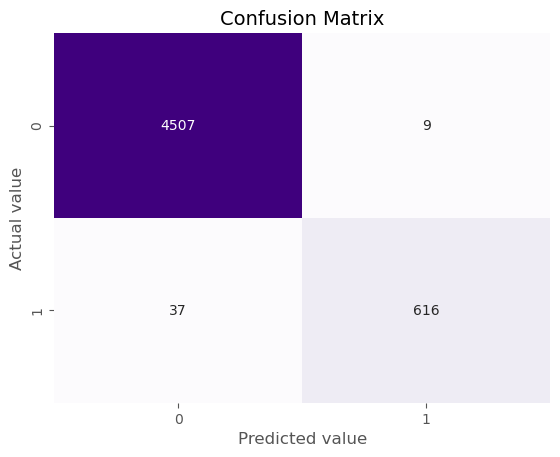

In [43]:
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d", cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted value', fontsize=12)
plt.ylabel('Actual value', fontsize=12)
plt.show()

### Naive Bayes 

In [44]:
gnb = GaussianNB()
accuracy, precision, recall, f1 = [], [], [], []
all_y_true, all_y_pred = [], []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    gnb.fit(X.iloc[train_index], y[train_index])
    y_pred = gnb.predict(X.iloc[test_index])
    
    all_y_true.extend(y[test_index])
    all_y_pred.extend(y_pred)
    
    accuracy.append(accuracy_score(y[test_index], y_pred))
    precision.append(precision_score(y[test_index], y_pred))
    recall.append(recall_score(y[test_index], y_pred))
    f1.append(f1_score(y[test_index], y_pred))
    
print(f"Avergae model accuracy: {round(sum(accuracy) / len(accuracy), 2)}")
print(f"Avergae model precision: {round(sum(precision) / len(precision), 2)}")
print(f"Avergae model recall: {round(sum(recall) / len(recall), 2)}")
print(f"Avergae model f1-score: {round(sum(f1) / len(f1), 2)}")

Avergae model accuracy: 0.98
Avergae model precision: 0.89
Avergae model recall: 0.95
Avergae model f1-score: 0.92


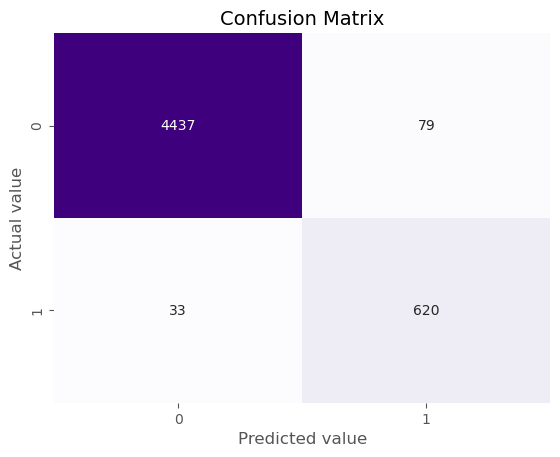

In [45]:
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure()
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d", cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted value', fontsize=12)
plt.ylabel('Actual value', fontsize=12)
plt.show()

In [46]:
print(classification_report(all_y_true, all_y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4516
           1       0.89      0.95      0.92       653

    accuracy                           0.98      5169
   macro avg       0.94      0.97      0.95      5169
weighted avg       0.98      0.98      0.98      5169



## Create the pipeline 

In [47]:
num_features = df_copy.drop(columns=['message', 'label'], axis=1).columns
df_copy.drop('label', axis=1, inplace=True)

preprocessor = ColumnTransformer([
    ('text', TextPreprocessor(), 'message'),
    ('scaling', StandardScaler(), num_features)
]
)

In [48]:
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [49]:
# Create the pipeline
rnd_forest_pipeline = Pipeline([
    ('renamer', Renamer()),
    ('feature_gen', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_jobs=-1))
])

xgboost_pipeline = Pipeline([
    ('renamer', Renamer()),
    ('feature_gen', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

naive_bayes_pipeline = Pipeline([
    ('renamer', Renamer()),
    ('feature_gen', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [50]:
df = pd.read_csv('./data/spam.csv', encoding='latin-1')
X = df.drop('v1', axis=1)

def encode(label):
    if label == 'spam':
        return 1 
    else:
        return 0

df['v1'] = df['v1'].apply(encode)
y = df['v1']

xgboost_pipeline.fit(X, y)

c:\Users\TERRA MOBILE\.conda\envs\spam_app\lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:34] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('renamer', Renamer()), ('feature_gen', FeatureGenerator()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('text', TextPreprocessor(),
                                                  'message'),
                                                 ('scaling', StandardScaler(),
                                                  Index(['message_length', 'num_digits', 'has_link', 'has_email', 'is_question',
       'contain_spam_keywords', 'spam_keywords_count', 'starts_with_greeting',
       'has_closing', 'num_s...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [51]:
# save xgboost model 
joblib.dump(xgboost_pipeline, './models/xgboost.joblib')

['./models/xgboost.joblib']

In [54]:
prediction = xgboost_pipeline.predict(pd.DataFrame([{
        'v1': 'ham',
        'v2': "WINNER!! As a valued network customer you have been selected to receivea �900 prize reward!",
        'Unnamed: 2': None,
        'Unnamed: 3': None,
        'Unnamed: 4': None,
    }]))
print(prediction[0])

1
